In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Feb 20 15:10:00 2018

@author: Yacalis
"""

import os
import json
import numpy as np
from Callbacks import Callbacks
from Config import Config
from dataLoader import retrieve_data, retrieve_celeba_data
from folder_defs import get_log_dir, get_data_dir, get_train_dir, get_test_dir, get_celeba_dir
from build_model import build_model
from save_model import save_model
from get_data_dict import get_data_dict, get_new_data_dict, get_celeba_data
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from Optimizer import Optimizer
from random import shuffle
import matplotlib.pyplot as plt

In [6]:
# get config
config = Config().config
# Model Checkpoint
config.period = 15
# ReduceLROnPlateau
config.lr_min_lr = 1e-07
# Training and testing
#config.optimizer = 'adam'
#config.complexity = 'celeba' # options: simple, complex, single, celeba
config.epochs = 10

unparsed config options: ['-f', '/Users/Yacalis/Library/Jupyter/runtime/kernel-5af503f7-c26c-4ed2-a43b-4968ba8d7e46.json']


In [7]:
# Callbacks
# Earlystopping
config.es_min_delta = 0.01
config.es_patience = 4
# ReduceLROnPlateau
config.lr_epsilon = 0.001
config.lr_factor = 0.5
config.lr_patience = 2
# Training and testing
config.batch_size = 4
config.change_lr = False
config.change_bs = False
# options for training loop
batch_size_mult = 2
# optimizer
optimizer = Adam(lr=0.001,  # 0.001
                 beta_1=0.9,  # 0.9
                 beta_2=0.999,  # 0.999
                 epsilon=1e-08,  # 1e-08
                 decay=0.0)  # 0.0

In [8]:
# get directories
log_dir = get_log_dir(config)
data_dir = get_data_dir()
image_dir = get_celeba_dir()

# get data
data_dict = get_celeba_data(data_dir)

# instantiate arrays
x_data = []
y_data = []
keys = data_dict.keys()
i = 1
images = os.listdir(image_dir)
shuffle(images)

data file:  /Users/Yacalis/Projects/Tensorflow/cs274c-data/celeba/list_attr.csv
number of records from data file:  159202


In [9]:
# load x and y data
try:
    for file in images:
        if i > 1000:
            break
        if file in keys:
            filepath = os.path.join(image_dir, file)
            im_arr = mpimg.imread(filepath)
            if im_arr.shape == (218, 178, 3):
                x_data.append(im_arr)
                y_data.append(np.array(data_dict[file][0]))
                i += 1
except Exception as e:
    print(str(e))

In [10]:
# turn into numpy arrays
x_data = np.array(x_data)
y_data = np.array(y_data)
print(x_data.shape)
print(y_data.shape, sum(y_data[:,1]), sum(y_data[:,1])/1000)

(1000, 218, 178, 3)
(1000, 3)
(1000, 3) 516 0.516


In [11]:
# split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, shuffle=True)
num_train = int(x_train.shape[0] * 0.8)
print(f'Num training examples (excludes test and val): {num_train}')

print(y_train.shape, sum(y_train[:,1]), sum(y_train[:,1])/1000)

Num training examples (excludes test and val): 640
(800, 3) 403 0.403


In [14]:
# build model
input_dim = x_train[0].shape

model = Sequential()
model.add(Conv2D(64,
                 kernel_size=(3, 3),
                 strides=(1, 1),
                 activation='relu',
                 padding='same',
                 input_shape=input_dim))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1)))
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=3, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics = ['accuracy'])
model.summary()

# model = Sequential()
# model.add(Conv2D(96,
#                  kernel_size=(7, 7),
#                  strides=(4, 4),
#                  activation='relu',
#                  padding='same',
#                  input_shape=input_dim))
# model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
# model.add(Conv2D(256,
#                  kernel_size=(5, 5),
#                  strides=(1, 1),
#                  activation='relu',
#                  padding='same'))
# model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
# model.add(Conv2D(384,
#                  kernel_size=(3, 3),
#                  strides=(1, 1),
#                  activation='relu',
#                  padding='same'))
# model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(3, activation='sigmoid'))

# model.compile(loss='mse',
#               optimizer=optimizer,
#               metrics = ['accuracy'])
# model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 218, 178, 64)      1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 216, 176, 64)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2433024)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1245708800
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 1539      
Total params: 1,245,712,131
Trainable params: 1,245,712,131
Non-trainable params: 0
_________________________________________________________________


In [15]:
# get callbacks
callbacks = Callbacks(config, log_dir).callbacks
print('callbacks:')
for callback in callbacks:
    print('\t', callback)

callbacks:


In [ ]:
# set variables
val_loss = []
val_acc = []
loss = []
acc = []
lr = []
bs = []
epoch_iter = 1
max_epochs = config.epochs
batch_size = config.batch_size

# train model
if config.change_lr:  # reduce_lr callback takes care of everything for us
    print('Will change learning rate during training, but not batch size')
    print('Training model...')
    history = model.fit(x_train,
                        y_train,
                        epochs=max_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.2,
                        verbose=1,
                        callbacks=callbacks)
    # store history (bs is constant)
    val_loss += history.history['val_loss']
    val_acc += history.history['val_acc']
    loss += history.history['loss']
    acc += history.history['acc']
    lr += history.history['lr']
    bs = [batch_size for i in range(len(history.epoch))]

elif config.change_bs:  # need to manually stop and restart training
    print('Will change batch size during training, but not learning rate')
    while max_epochs >= epoch_iter:
        print(f'Currently at epoch {epoch_iter} of {max_epochs}, batch size is {batch_size}')
        epochs = max_epochs - epoch_iter + 1
        history = model.fit(x_train,
                            y_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            shuffle=True,
                            validation_split=0.2,
                            verbose=1,
                            callbacks=callbacks)
        # store history
        val_loss += history.history['val_loss']
        val_acc += history.history['val_acc']
        loss += history.history['loss']
        acc += history.history['acc']
        bs += [batch_size for i in range(len(history.epoch))]

        # update training parameters
        epoch_iter += len(history.epoch)
        batch_size *= batch_size_mult
        batch_size = batch_size if batch_size < num_train else num_train

    # store lr history as constant (because it is)
    lr = [0.001 for i in range(len(bs))]

else:
    print('Will not change learning rate nor batch size during training')
    print('Training model...')
    history = model.fit(x_train,
                        y_train,
                        epochs=max_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.2,
                        verbose=1,
                        callbacks=callbacks)
    # store history (bs is constant)
    val_loss += history.history['val_loss']
    val_acc += history.history['val_acc']
    loss += history.history['loss']
    acc += history.history['acc']
    lr = [0.001 for i in range(len(history.epoch))]
    bs = [batch_size for i in range(len(history.epoch))]

print('Completed training')

Will not change learning rate nor batch size during training
Training model...
Train on 640 samples, validate on 160 samples


In [171]:
# save finished model -- overrides original model saved before training
save_model(log_dir=log_dir, config=config, model=model)

# save loss, accuracy, lr, and bs values across epochs as json;
# have to force cast lr vals as float64 because history object saves them
# as float32, and json.dump() is not compatible with float32
acc_loss_lr_bs = {'val_loss': val_loss,
                  'val_acc': val_acc,
                  'loss': loss,
                  'acc': acc,
                  'lr': [np.float64(i) for i in lr],
                  'bs': bs
                  }
acc_loss_lr_bs_path = os.path.join(log_dir, 'acc_loss_lr_bs.json')
with open(acc_loss_lr_bs_path, 'w') as f:
    json.dump(acc_loss_lr_bs, f, indent=4, sort_keys=True)

Saving model...
Model saved


In [172]:
# evaluate model (on original batch size)
print('Calculating final score...')
score = model.evaluate(x_test, y_test, batch_size=config.batch_size)
print('Final score:', score)

Calculating final score...
200/200 [==============================] - 7s 34ms/step
Final score: [0.3950000105798244, 0.23]


[0 1 1] [2]
[0 0 1] [2]
[0 0 0] [2]
[0 1 0] [2]
[0 1 1] [2]
[0 0 0] [2]
[0 1 0] [2]
[0 1 0] [2]
[0 0 1] [2]
[0 1 0] [2]


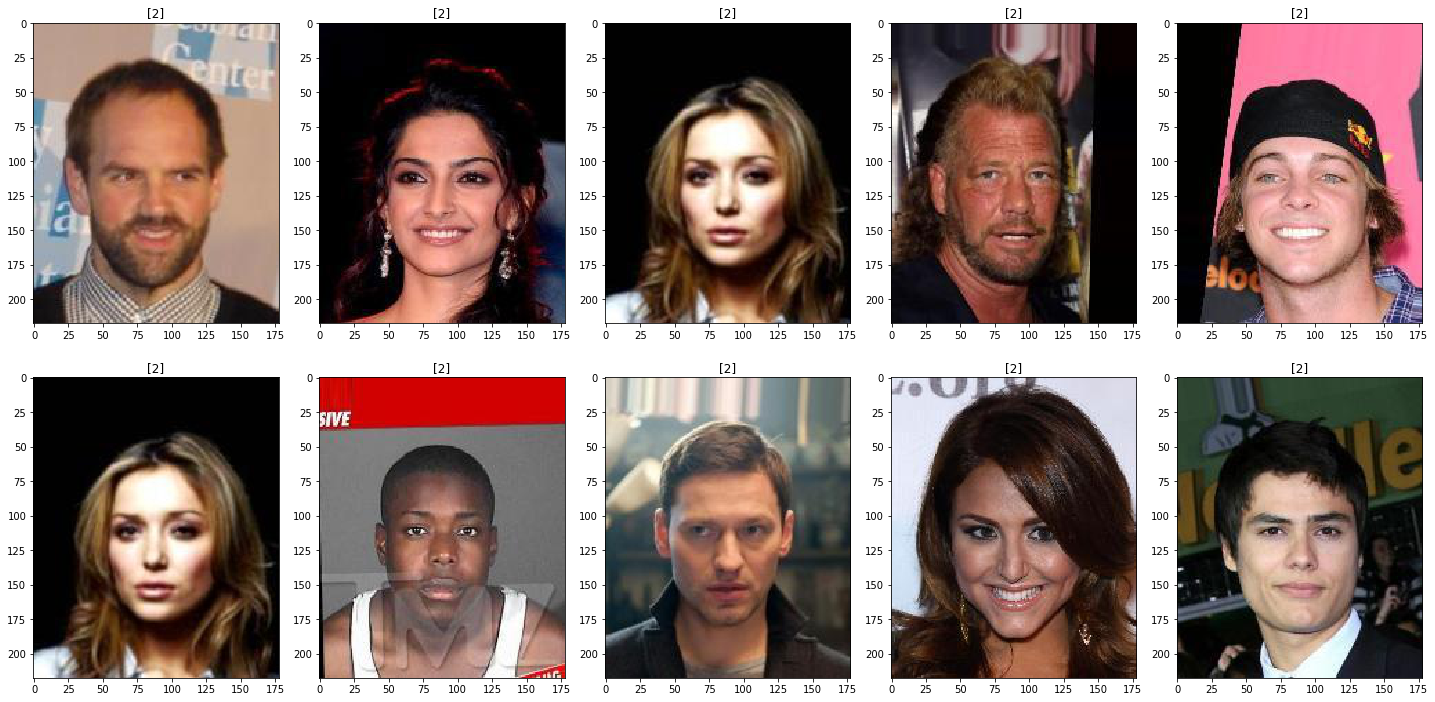

In [179]:
# show examples
plt.figure(figsize=(20,10))
columns = 5
k = 0
max_iter = 9
while k < (max_iter + 1):
    rando = np.random.randint(0, len(x_test) - 1)
    image = x_test[rando]
    plt.subplot((max_iter - 1) / columns + 1, columns, k + 1)
    plt.imshow(image)
    pred = model.predict(np.expand_dims(x_test[rando], axis=0))
#     pred = model.predict_on_batch(np.expand_dims(x_test[rando], axis = 0))
#     pred = model.predict_classes(np.expand_dims(x_test[rando], axis = 0))
    plt.title(f'{pred}')
    print(y_test[rando], pred)
    k += 1
plt.tight_layout()